## Installs

Installation of **[transformers](https://github.com/huggingface/transformers)** and **[ml_things](https://github.com/gmihaila/ml_things)**.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -q git+https://github.com/gmihaila/ml_things.git

In [2]:
# !pip install odfpy

Install matplotlib 3.1.3

In [3]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

## Imports

Import necessary libraries



In [4]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

## Declaration of parameters


Declare parameters used in this notebook

In [5]:

# Number of training epochs 
epochs = 5

# Number of batch_size - depending on the max sequence length and avaialable GPU memory
# For 512 sequence length batch of 10 works without cuda memory issues
# For small sequence length one can try batch of 32 or higher
batch_size = 16

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model
max_length = 312

# Look for gpu to use. Will use `cpu` by default if no gpu found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of the transformers model - will use already pretrained model
# Path of transformer model - will load your own model from local disk

#model_name_or_path = "monsoon-nlp/hindi-bert"
model_name_or_path = "ai4bharat/indic-bert"
#model = AutoModelForMaskedLM.from_pretrained("ai4bharat/IndicBERTv2-SS")

# Dicitonary of labels and their id - this will be used to convert string labels to number.
labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

# How many labels are we using in training
# This is used to decide size of classification head
n_labels = len(labels_ids)

## Load the Hindi review dataset

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Load the review dataset

In [12]:
import pandas as pd

# Assuming your CSV file is named 'HINDI_dataset.csv' in the same directory
df = pd.read_csv("/kaggle/input/actsa-indicbert/data_with_sentiment_labels.csv", names=["review", "sentiment"])

# Display the first few rows of the DataFrame
df = df.iloc[1:]  # Select rows starting from index 1 (excluding the first row)

df.head()

,review,sentiment
1,పరువునష్టాన్ని కలిగించే చర్యలను 1860 నాటి భారత...,neutral
2,వాహనంలో ఉన్న పోలీసు సిబ్బందికి బుల్లెట్ ప్రూఫ్...,positive
3,"దేశంపట్ల కానీ, ప్రజలపట్ల కానీ బాధ్యత కనిపించదు.",negative
4,ఒక పనిమనిషి కుమారుడు ఈ దేశ ప్రధాని కావడం అంబేద...,neutral
5,మత ప్రాతిపదికన మనుషుల్ని రెచ్చగొట్టే ఉగ్రవాదం ...,neutral


In [13]:
df["sentiment"] = [0 if i== "negative" else 1 if i=="neutral" else 2 for i in df["sentiment"]]

In [15]:
df.head()

,review,sentiment
1,పరువునష్టాన్ని కలిగించే చర్యలను 1860 నాటి భారత...,1
2,వాహనంలో ఉన్న పోలీసు సిబ్బందికి బుల్లెట్ ప్రూఫ్...,2
3,"దేశంపట్ల కానీ, ప్రజలపట్ల కానీ బాధ్యత కనిపించదు.",0
4,ఒక పనిమనిషి కుమారుడు ఈ దేశ ప్రధాని కావడం అంబేద...,1
5,మత ప్రాతిపదికన మనుషుల్ని రెచ్చగొట్టే ఉగ్రవాదం ...,1


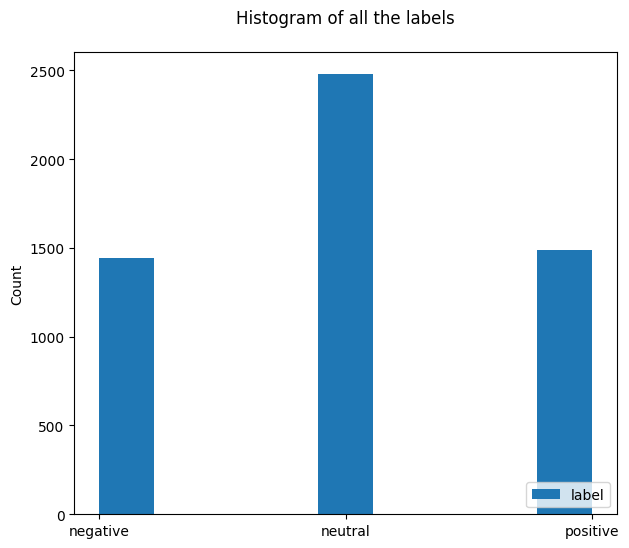

In [16]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of all the labels\n')
plt.hist([df["sentiment"]], bins, label=['label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

Save the data as csv

In [34]:
# df.to_csv('/content/drive/MyDrive/The-London-Story/Supervised-NLP-tasks/Production/HINDI_dataset.csv', index=False)

Split the data into train, test and validation sets

In [17]:
train, val, test = np.split(df.sample(frac=1), [int(.75*len(df)), int(.82*len(df))])

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
print ("Size of training dataset-->", len(train))
print ("Size of test dataset-->", len(test))
print ("Size of validation dataset-->", len(val))

Size of training dataset--> 4057
Size of test dataset--> 974
Size of validation dataset--> 379


Extract training, testing and validation texts and labels

In [19]:
train_text = list(train ['review'])
train_labels = list(train ['sentiment'])

test_text = list(test ['review'])
test_labels = list(test ['sentiment'])

val_text = list(val ['review'])
val_labels = list(val ['sentiment'])

Plot a historgram with the distribution of training labels

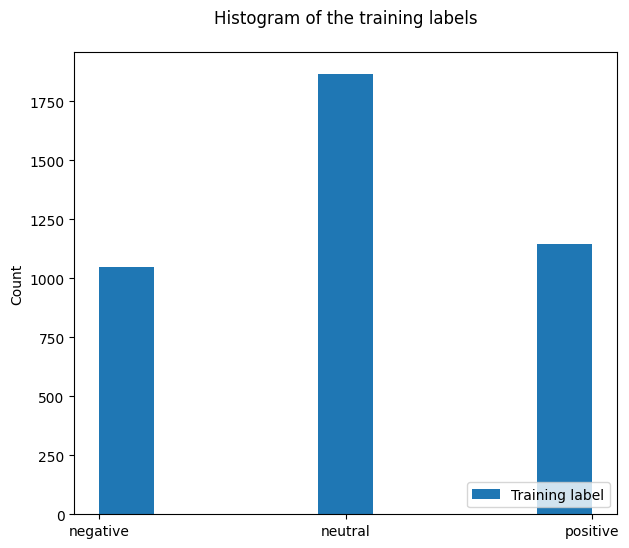

In [20]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of the training labels\n')
plt.hist([train_labels], bins, label=['Training label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

## Define helper class and functions

Classes and functions that are used in this notebook:

* MyDataset
* train
* validation

Define `MyDatset` class

In [21]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

**Define `train` function:**


Train a pytorch model on a single pass through the data loader. It will use the global variable `model` which is the transformer model loaded on `_device` that we want to train on.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].


See `Hugging Face` documentation on [training and fine-tuning transformers](https://huggingface.co/transformers/v3.5.1/training.html) in native PyTorch.

In [22]:
def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch
  total_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data we run the loop
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because we have provided the `labels`.
    # The documentation for a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
    # We will use logits later to calculate training accuracy.
    #loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

    # Alternatively, you can just get the logits and calculate the loss yourself as follows
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits


    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
    # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss

**Define `validation` function:**

Validation function to evaluate model performance on a separate set of data. This function will return the true and predicted labels so we can use later to evaluate the model's performance.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]


In [23]:
def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## Load config, tokenizer and the model

Loading the three esential parts of pretrained transformers: 

* configuration, 
* tokenizer and 
* model. 

We also need to load the model to the device we're planning to use (GPU / CPU).

In [24]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading model configuraiton...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

Loading model tokenizer...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Loading the model...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## Data encoding and create DataLoader object

Create data encodings

In [25]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

train_dataset = MyDataset(train_encodings, train_labels)
valid_dataset = MyDataset(valid_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

Create DataLoader objects that will be fed into our model

In [26]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 254 batches!
Created `test_dataloader` with 61 batches!
Created `valid_dataloader` with 24 batches!


## Train the model

**Steps:**

1. Create optimizer and scheduler used by PyTorch in training

2. Loop through the number of defined epochs and call the **train** and **validation** functions

3. Store the outputs, which are similar info after each epoch as in Keras: *train_loss,   val_loss,   train_acc, valid_acc*

4. After training, plot train and validation loss and accuracy curves to check how the training went

In [27]:
optimizer = AdamW (model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
  print()

  print('Training on batches...')
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score (train_labels, train_predict)

  # Get prediction from model on validation data
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
  val_acc = accuracy_score (valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss values for plotting the learning curve
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Store the accuracy values
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/5 [00:00<?, ?it/s]


Training on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/254 [00:00<?, ?it/s]

Validation on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/24 [00:00<?, ?it/s]

  train_loss: 1.07068 - val_loss: 1.06681 - train_acc: 0.45329 - valid_acc: 0.45646


Training on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/254 [00:00<?, ?it/s]

Validation on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/24 [00:00<?, ?it/s]

  train_loss: 1.06453 - val_loss: 1.06723 - train_acc: 0.45970 - valid_acc: 0.45646


Training on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/254 [00:00<?, ?it/s]

Validation on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/24 [00:00<?, ?it/s]

  train_loss: 1.06313 - val_loss: 1.06885 - train_acc: 0.45970 - valid_acc: 0.45646


Training on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/254 [00:00<?, ?it/s]

Validation on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/24 [00:00<?, ?it/s]

  train_loss: 1.05518 - val_loss: 1.05947 - train_acc: 0.45970 - valid_acc: 0.45646


Training on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/254 [00:00<?, ?it/s]

Validation on batches...


/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/24 [00:00<?, ?it/s]

  train_loss: 1.02744 - val_loss: 1.04758 - train_acc: 0.46882 - valid_acc: 0.43799



Plot the loss and accuracy curves

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have stored the ground truth labels and predictions during validation
# valid_labels, valid_predict

# Convert labels and predictions to numpy arrays
valid_labels = np.array(valid_labels)
valid_predict = np.array(valid_predict)

# Calculate precision, recall, and F1 score
precision = precision_score(valid_labels, valid_predict, average='weighted')
recall = recall_score(valid_labels, valid_predict, average='weighted')
f1 = f1_score(valid_labels, valid_predict, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.47281528359156466
Recall: 0.43799472295514513
F1 Score: 0.36039518319457586


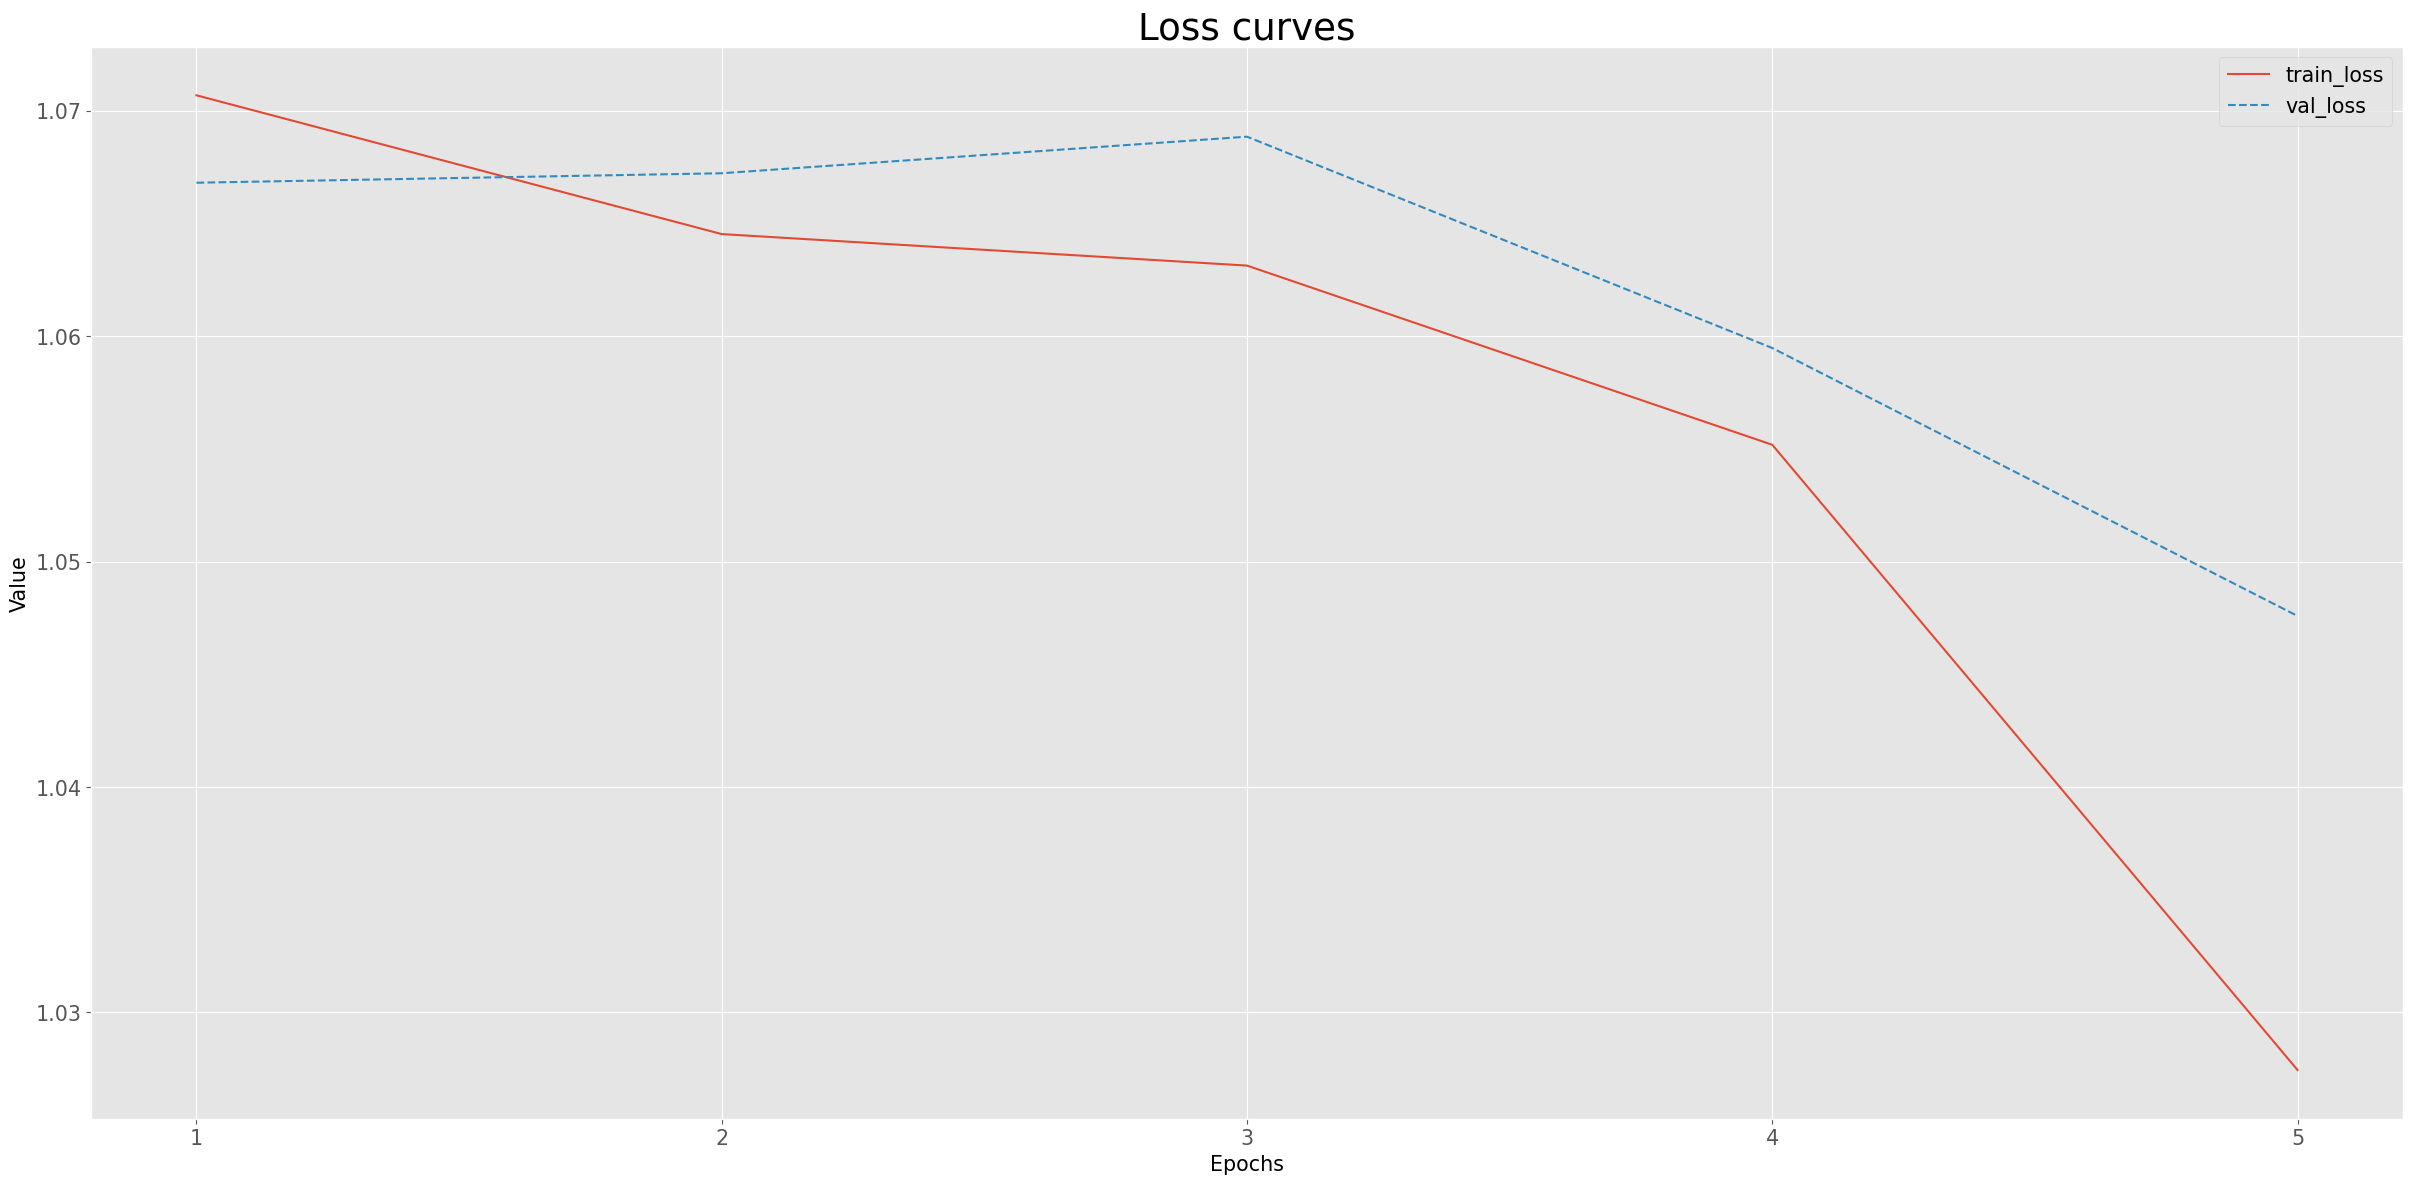

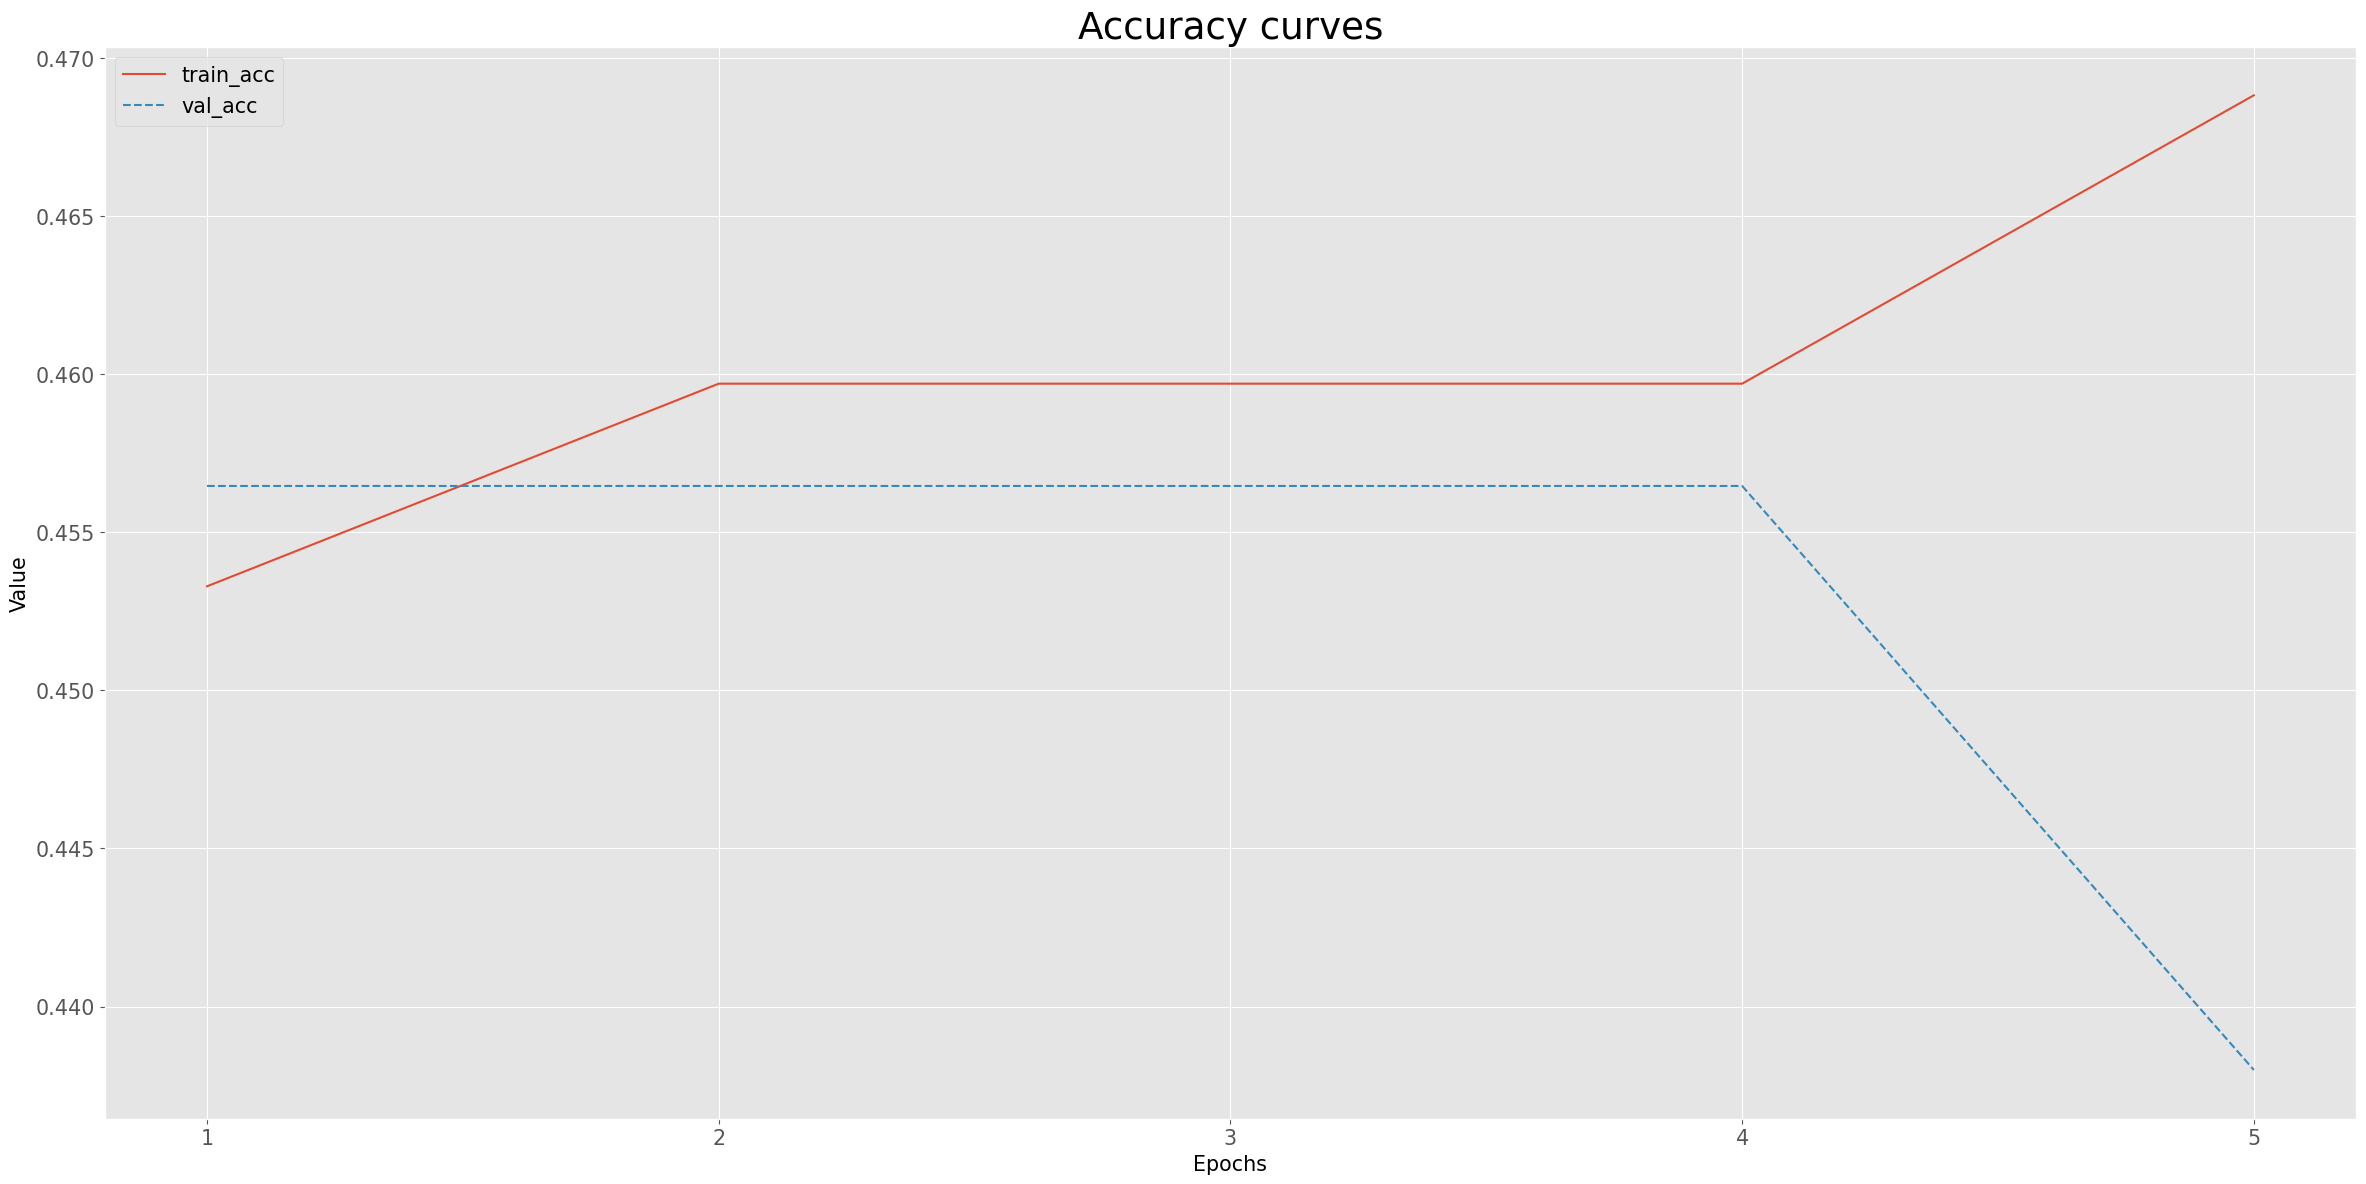

In [29]:
# Plot the loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_title='Loss curves', use_linestyles=['-', '--'], magnify=0.2)

# Plot the accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_title='Accuracy curves', use_linestyles=['-', '--'], magnify=0.2)

## Evaluation on the test dataset



Re-load the model to test whether it saved properly or not